# 9. 성능 개선
## 9.2 데이터 불균형


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
cd/content/gdrive/My Drive/pytorch_dlbro

/content/gdrive/My Drive/pytorch_dlbro


## Weighted Random Sampling


In [ ]:
# 각 클래스의 비율을 정하여 뽑힐 확률에 대한 가중치를 산정한다.
import torch
from torch.utils.data import DataLoader
import torchvision
import numpy as np
import torchvision.transforms as tr 

def make_weights(labels, nclasses):
    labels = np.array(labels)
    weight_list = []
    for cls in range(nclasses):
        idx = np.where(labels == cls)[0]
        count = len(idx)
        weight = 1 / count
        weights = [weight] * count
        weight_list += weights
    return weight_list
"""
torchvision.datasets.ImageFolder를 사용할 경우 라벨이 정렬이 되어 데이터가 만들어 집니다. 
따라서 라벨을 기준으로 순차적으로 가중치를 할당하면 됩니다. 
만약 클래스가 순차적으로 정렬되어 있지 않은 데이터인 경우 인덱싱이 매칭되지 않아 아래 코드를 사용하셔야 합니다.

def make_weights(labels, nclasses):
    labels = np.array(labels) # where, unique 함수를 사용하기 위해 numpy로 변환한다.
    weight_arr = np.zeros_like(labels) # 가중치를 저장하는 배열을 생성한다.
    _, counts = np.unique(labels, return_counts=True) # 각 클래스의 데이터 개수를 센다.
    for cls in range(nclasses):
        weight_arr = np.where(labels == cls, 1/counts[cls], weight_arr) 
        # 각 클래스의의 인덱스를 산출하여 해당 클래스 개수의 역수를 확률로 할당한다.
        # 이를 통해 각 클래스의 전체 가중치를 동일하게 한다.

    return weight_arr
"""

In [ ]:
transf = tr.Compose([tr.Resize((16,16)),tr.ToTensor()]) 
trainset = torchvision.datasets.ImageFolder(root='./class', transform=transf) # 데이터 세트 불러오기

weights = make_weights(trainset.targets, len(trainset.classes)) # 가중치 계산
weights = torch.DoubleTensor(weights) # 텐서 변환
print(weights)
sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights)) # 샘플링 방법 정의

trainloader_wrs = DataLoader(trainset, batch_size=6, sampler=sampler) # 데이터 로더 정의
trainloader_rs = DataLoader(trainset, batch_size=6, shuffle=True)

tensor([0.2500, 0.2500, 0.2500, 0.2500, 0.0714, 0.0714, 0.0714, 0.0714, 0.0714,
        0.0714, 0.0714, 0.0714, 0.0714, 0.0714, 0.0714, 0.0714, 0.0714, 0.0714],
       dtype=torch.float64)


In [ ]:
for epoch in range(3):
    for data in trainloader_wrs:
        print(data[1])

tensor([0, 1, 0, 1, 1, 1])
tensor([0, 1, 1, 0, 1, 0])
tensor([1, 1, 1, 1, 1, 0])
tensor([0, 0, 0, 1, 1, 0])
tensor([0, 0, 1, 0, 1, 0])
tensor([1, 1, 0, 0, 1, 1])
tensor([1, 0, 0, 0, 0, 1])
tensor([0, 1, 0, 0, 1, 1])
tensor([1, 0, 1, 1, 0, 0])


In [ ]:
for epoch in range(5):
    for data in trainloader_rs:
        print(data[1])

tensor([1, 1, 0, 0, 1, 1])
tensor([1, 1, 0, 1, 1, 1])
tensor([1, 1, 1, 0, 1, 1])
tensor([1, 1, 1, 0, 0, 1])
tensor([1, 1, 1, 1, 0, 1])
tensor([0, 1, 1, 1, 1, 1])
tensor([1, 1, 0, 0, 1, 1])
tensor([1, 0, 1, 1, 1, 1])
tensor([1, 1, 1, 0, 1, 1])
tensor([1, 0, 1, 1, 1, 0])
tensor([1, 1, 0, 1, 0, 1])
tensor([1, 1, 1, 1, 1, 1])
tensor([1, 1, 1, 0, 1, 1])
tensor([1, 1, 1, 1, 0, 1])
tensor([0, 1, 1, 1, 0, 1])


## Weighted Loss Function

In [ ]:
import torch.nn as nn
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
num_ins = [40,45,30,62,70,153,395,46,75,194]
weights = [1-(x/sum(num_ins)) for x in num_ins]
class_weights = torch.FloatTensor(weights).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

## Confusion Matrix

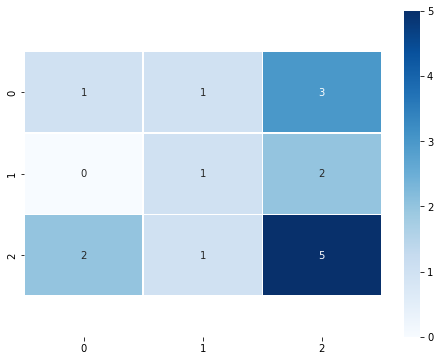

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
from matplotlib import pyplot as plt

actual = [1,1,1,0,0,0,0,0,2,2,2,2,2,2,2,2]
prediction = [1,2,2,0,2,2,1,2,0,1,0,2,2,2,2,2]
c_mat = confusion_matrix(actual, prediction) # 실제 라벨, 예측값
plt.figure(figsize = (8,6))
sns.heatmap(c_mat, annot=True, fmt="d", cmap='Blues',linewidths=.5)
b, t = plt.ylim() 
b += 0.5 
t -= 0.5 
plt.ylim(b, t) 
plt.savefig('confusion_matrix.png')
plt.show()